# 08 텍스트 분석

## 10 텍스트 분석 실습 - 캐글 Mericari Price Suggestion Challenge

https://www.kaggle.com/c/mercari-price-suggestion-challenge/data 에서 데이터 다운로드

Mercari Price Suggestion Challenge 데이터는 일본의 대형 온라인 쇼핑몰인 Mercari사의 제품에 대해 가격을 예측하는 과제이다.

+ 데이터 세트의 속성
  + train_id : 데이터 id
  + name : 제품명
  + item_condition_id : 판매자가 제공하는 제품 상태
  + category_name : 카테고리 명
  + brand_name : 브랜드 이름
  + price : 제품 가격, 예측을 위한 타깃 속성
  + shipping : 배송비 무료 여부, 1이면 무료(판매자가 지불), 0이면 유료(구매자 지불)
  + item_description : 제품에 대한 설명

이들 중 price가 예측할 값, item_description과 같은 텍스트 형태의 비정형 데이터와 다른 정형 속성을 같이 적용해 회귀를 수행한다.

#### 데이터 전처리

In [3]:
from sklearn.linear_model import Ridge , LogisticRegression
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('mercari_df.tsv',sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [4]:
# 피처의 타입과 Null 여부를 확인하기
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


+ brand_name 칼럼은 가격에 영향을 미치는 중요 요인으로 판단되지만 매우 많은 Null값을 가지고 있음
+ category_name은 6300건의 null 데이터를 가지고 있음
+ item_desciption의 null 값은 4건으로 미비

이 Null 데이터는 이후에 적절한 문자열로 치환한다.

Target 값인 price 칼럼의 데이터 분포도를 살펴본다.

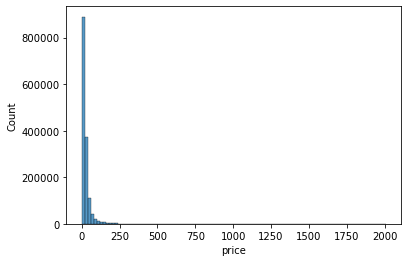

In [5]:
# price 칼럼의 데이터 간 분포도 확인
import matplotlib.pyplot as plt
import seaborn as sns

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.histplot(y_train_df, bins=100)
plt.show()

price 값이 비교적 적은 가격을 가진 데이터 값에 왜곡돼 분포돼 있다. Price 칼럼을 로그 값을 변환한뒤 분포도를 다시 살펴본다.

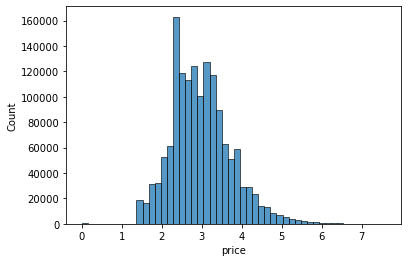

In [6]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.histplot(y_train_df, bins=50)
plt.show()

로그 값으로 변환하면 price값이 비교적 정규 분포에 가까운 데이터를 이루게 되므로 데이터 세트의 price 칼럼을 원래 값에서 로그로 변환된 값으로 변경한다.

In [7]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

shipping과 item_condition_id 피처 살펴보기

In [8]:
print('Shipping 값 유형:\n',mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n',mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 0    819435
1    663100
Name: shipping, dtype: int64
item_condition_id 값 유형:
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


Shipping 칼럼은 배송비 유무를 의미하며, 값이 비교적 균일하다.

Item_condtion_id는 판매자가 제공하는 제품 상태로서 1,2,3 값이 주를 이루고 있다.

description에 대한 별도 설명이 없는 경우 'No description yet' 값으로 돼 있다. 이러한 값이 얼마나 있는지 살펴본다.

In [9]:
boolean_cond= mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

'No description yet'의 경우 Null과 마찬가지로 의미있는 속성값으로 사용될 수 없으므로 적절한 값으로 변경해야 한다.

categroy_name 은 '/'로 분리된 카테고리를 하나의 문자열로 나타내고 있다.

Men/Tops/T-shirts 는 대분류 Men, 중분류 Tops, 소분류 T-shirts로 나눌 수 있다. 

category_name 은 텍스트 이므로 피처 추출시 tokenizer를 '/'로 하여 단어를 분리해 벡터화할 수도 있지만  category_name의 '/'를 기준으로 단어를 토큰화해 가각 별도의 피처로 저장하고 이를 이용해 알고리즘을 학습시킨다.

In [11]:
# category_name 칼럼을 '/' 기준으로 분리해 내기 위해 split_cat() 함수 생성
# apply lambda에서 호출되는 대,중,소 분할 함수 생성, 대,중,소 값을 리스트 반환

def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null' , 'Other_Null' , 'Other_Null']

# 위의 split_cat( )을 apply lambda에서 호출하여 대,중,소 컬럼을 mercari_df에 생성. 
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
                        zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 갯수만 추출
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('중분류 갯수 :', mercari_df['cat_jung'].nunique())
print('소분류 갯수 :', mercari_df['cat_so'].nunique())

대분류 유형 :
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 갯수 : 114
소분류 갯수 : 871


마지막으로 brand_name, category_name, item_description 칼럼의 Null 값은 일괄적으로 'Other Null'로 동일하게 변경한다.

In [12]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 컬럼별로 Null값 건수 확인. 모두 0가 나와야 합니다.
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

#### 피처 인코딩과 피처 벡터화

문자열 칼럼 중 레이블 또는 원-핫 인코딩을 수행하거나 피처 벡터화로 변환할 칼럼을 선별한다. 예측 모델은 상품 가격을 예측해야하므로 회귀 모델을 기반으로 한다. 선형 회귀의 경우 원-핫 인코딩 적용이 선호되므로 인코딩할 피처는 모두 원-핫 인코딩을 적용한다.

피처 벡터화의 경우는 비교적 짧은 텍스트의 경우는 Count 기반의 벡터화를, 긴 텍스트는  TD-IDF 기반의 벡터화를 적용한다.

1. brand_name 칼럼 검토
   + brand_name은 상품의 브랜드명
   + 상품 브랜드명이 어떤 유형으로 돼 있는지 유형 건수와 대표적인 브랜드명을 5개 정도 살펴본다.

In [13]:
print('brand name 의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5])

brand name 의 유형 건수 : 4810
brand name sample 5건 : 
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


대부분 명료한 문자열로 돼 있으므로 인코딩 변환을 적용한다.

2. name 칼럼 검토
    + 어떤 유형으로 돼 있는지 유형 건수와 상품명을 7개만 출력

In [14]:
print('brand name 의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5])
print('name 의 종류 갯수 :', mercari_df['name'].nunique())
print('name sample 7건 : \n', mercari_df['name'][:7])

brand name 의 유형 건수 : 4810
brand name sample 5건 : 
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64
name 의 종류 갯수 : 1225273
name sample 7건 : 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


Name 속성은 유형이 매우 많고, 적은 단어 위주의 텍스트 형태로 돼 있으므로 Count기반으로 피처 벡터화 변환을 적용한다.

3. categroy_name 칼럼
    + 전처리를 통해 대, 중 , 소 세개의 칼럼으로 분리됐으므로 원-핫 인코딩을 적용한다.

4. shipping 칼럼
   + 0 과 1 두가지 유형의 값을 가지고 있으므로 원-핫 인코딩 적용

5. item_condition_id 칼럼
   + 상품 상태로서 1,2,3,4,5 다섯 가지 유형의 값을 가지고 있으므로 원-핫 인코딩 적용 


6. item_description
    + item_description은 상품에 대한 간단 설명으로 데이터 세트에서 가장 긴 텍스트를 가지고 있다.

In [15]:
# 해당 칼럼의 평균 문자열 크기와 2개 정도의 텍스트만 추출
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 개수
print('item_description 평균 문자열 개수:',mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 개수: 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

평균 문자열이 145자로 비교적 크므로 해당 칼럼은 TF-IDF로 변환한다.

__주요 칼럼을 인코딩 및 피처 벡터화 변환__

+ name과 item_description 칼럼을 피처 벡터화
  + name 칼럼 -> countVectorizer
  + item_description -> TfidVectorizer

In [16]:
# name 속성에 대한 feature vectorization 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description 에 대한 feature vectorization 변환 
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range= (1,3) , stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:',X_name.shape)
print('item_description vectorization shape:',X_descp.shape)

KeyboardInterrupt: 

CountVectorizer, TfidVectorizer가 fit_transform()을 통해 반환하는 데이터는 희소 행렬 형태이다. 희소 행렬 객체 변수인 X_name과 X_descp를 새로 결합해 새로운 데이터 세트로 구성해야 하고, 앞으로 인코딩 될 cat_dae, cat_jung, cat_so, brand_name, shipping, item_condition_id도 모두 X_name, X_descip와 결합돼 ML 모델을 실행하는 기반 데이터 세트로 재구성돼야 한다.

이를 위해 인코딩 대상 칼럼도 밀집 행렬 형태가 아닌 희소 행렬 형태로 인코딩을 적용한 뒤 함께 결합한다.

사이킷런은 원-핫 인코딩을 위해 OneHotEnconder와 LabelBinarizer 클래스를 제공한다. 이 중 LabelBinarizer 클래스는 희소 행렬 형태의 원-핫 인코딩 변환을 지원한다. (생성 시 sparse_out=True로 설정)

LabelBinarizer를 이용해 희소 행렬 형태의 원-핫 인코딩 변환한다. 개별 칼럼으로 만들어진 희소 행렬은 사이파이 패키지 sparse모듈의 hstack()함수를 이용해 결합한다.

In [ ]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name= LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

제대로 변환됐는지 생성된 인코딩 데이터 세트의 타입과 shape 살펴보기

In [ ]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

brand_name, X_brand_shape,X_cat_so 의 경우 매우 많은 칼럼을 가지게 되었지만 피처 벡터화로 텍스트 형태의 문자열이 가지는 벡터 형태의 매우 많은 칼럼과 함께 결합되므로 크게 문제 되지 않는다.

피처 벡터화 변환한 데이터 세트와 희소 인코딩 변환된 데이터 세트를 hstack()을 이용해 모두 결합해 본다. 만들어진 결합 데이터가 비교적 많은 메모리를 잡아먹기 때문에 del'객체 변수명'과 gc.collect()로 결합 데이터를 메모리에서 삭제한다. 추후에 다양한 모델을 적용할때마다 다시 결합해 해당 데이터 세트를 이용한다.

In [ ]:

from  scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,
            X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# 사이파이 sparse 모듈의 hstack 함수를 이용하여 앞에서 인코딩과 Vectorization을 수행한 데이터 셋을 모두 결합. 
X_features_sparse= hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 셋이 메모리를 많이 차지하므로 사용 용도가 끝났으면 바로 메모리에서 삭제. 
del X_features_sparse
gc.collect()

hstack()으로 결합한 데이터 세트는 csr_matrix 타입이며, 총 1615679개의 피처를 가진다. 이제 회귀를 적용해 price값을 예측할 수 있도록 모델을 만든다.

#### 릿지 회귀 모델 구축 및 평가

여러 알고리즘 모델과 희소행렬을 변환하고 예측 성능을 비교함ㄴ서 테스트를 수행할 것이므로 수행에 필요한 로직을 함수화한다.

모델을 평가할 지표는 RMSLE 방식으로 한다.

In [ ]:
def rmsle(y , y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산 
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test , preds): 
    
    # 원본 데이터는 log1p로 변환되었으므로 exmpm1으로 원복 필요. 
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    
    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

학습용 데이터를 생성하고, 모델을 학습/예측 하는 로직을 함수로 만든다.

In [ ]:
import gc 
from  scipy.sparse import hstack

def model_train_predict(model,matrix_list):
    # scipy.sparse 모듈의 hstack 을 이용하여 sparse matrix 결합
    X= hstack(matrix_list).tocsr()     
    
    X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'], 
                                                      test_size=0.2, random_state=156)
    
    # 모델 학습 및 예측
    model.fit(X_train , y_train)
    preds = model.predict(X_test)
    
    del X , X_train , X_test , y_train 
    gc.collect()
    
    return preds , y_test

이제 이를 이용해 먼저 Ridge를 이용해 Mercari Price의 회귀 예측을 수행한다.

수행 전에 Mercari 상품 가격 예측에 item_description과 같은 텍스트 형태의 속성이 얼마나 영향을 미치는지 알아본다.

Item_description 속성의 피처 벡터화 데이터가 포함되지 않았을 때와 포함됐을 때의 예측 성능을 비교한다.

In [ ]:
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test , linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test ,linear_preds))

Item Description을 포함했을 때 rmsle 값이 많이 감소했다. 이느느 Item description 영향이 중요함을 알 수 있다.

#### LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

LightGBM을 이용해 회귀를 수행한 뒤, 위에서 구한 릿지 모델 예측값과 LightGBM모델 예측값을 간단한 앙상블(Ensemble) 방식으로 섞어서 최종 회귀 예측값을 평가한다.

먼저 LightGBM으로 회귀를 수행한다. n_estimators를 1000 이상 증가시키면 예측 성능은 조금 좋아지나 수행시간이 1시간 이상 걸리므로 n_estimatros를 200으로 작게 설정하고 예측 성능을 측정해본다.

In [ ]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds , y_test = model_train_predict(model = lgbm_model , matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:',  evaluate_org_price(y_test , lgbm_preds))

릿지 보다 예측 성능이 더 나아졌다. 이렇게 구한 LightGBM의 예측 결괏값과 위에서 구한 Ridge의 예측 결과값을 서로 앙상블해 최종 예측 결과값을 도출한다.

In [ ]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))